# Visualising & understanding high-dimensional data

## Introduction

In this project I will explore a range of techniques for visualising & understanding very high dimensional datasets  - which can be very challenging to use, observe & understand. Visualising higher dimensional datasets can have various purposes & objectives such as:

- Understanding the dataset & subject it represents better
- Preparing the data for machine learning algorithms

We will use the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digit images which has 784 dimensions/features per image.

The techniques we will use to visualise this dataset will be:

- **PCA** (Principal components analysis)
- **t-SNE** (t-Distributed Stochastic Neighbour Embedding)
- **TDA** (Topological data analysis)

These are different techniques that aim to reduce down a datasets complexity to something easier to understand, either for humans or for machine learning algorithms (i.e. for classification).


## Load libraries and view dataset

We will first load in the required libraries and explore the dataset a little.

In [1]:
# Import libs
from __future__ import print_function
import time
import numpy as np
import pandas as pd
try:
    import umap
except ImportError:
    print("This example requires the UMAP library. You can install it with the command `!pip install umap-learn`")
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import io
import sys
import base64
import matplotlib.pyplot as plt
import kmapper as km
import scipy
import imageio
import seaborn as sns

%matplotlib inline

/home/kahama/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# Show dimensions of digit image data
print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
# Convert feature matrix X and target vector y to a pandas dataframe.
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


In [4]:
# For reproducability of the results
np.random.seed(42)
# Take random subset of digit images so we get a range of examples for each digit
rndperm = np.random.permutation(df.shape[0])

<Figure size 640x480 with 0 Axes>

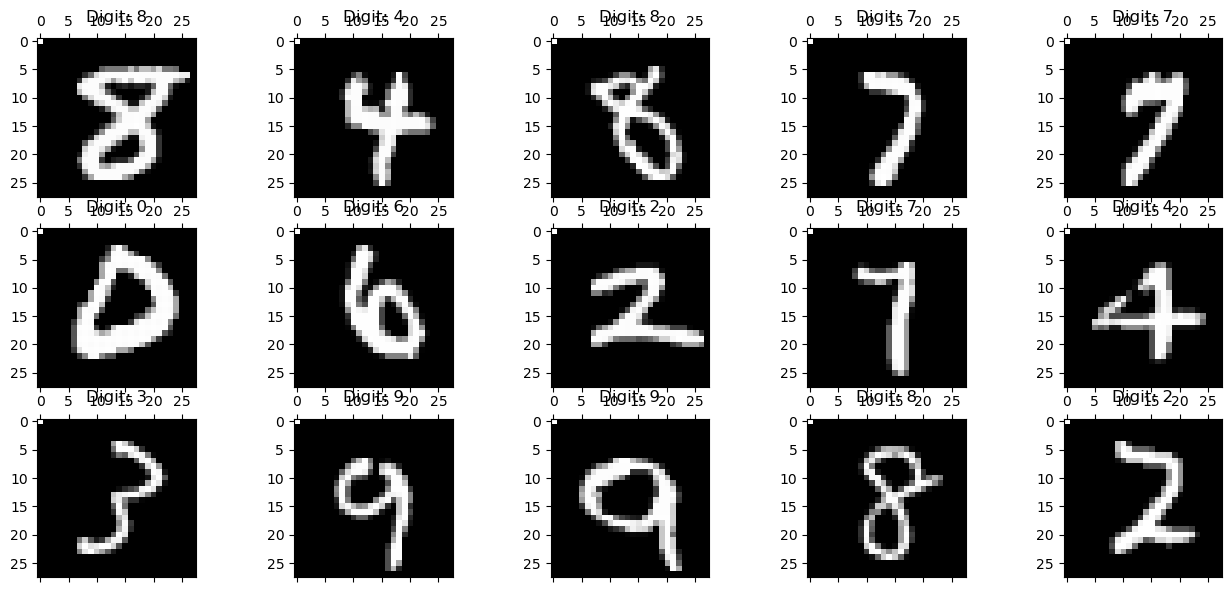

In [5]:
# Print examples
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

This gives us some idea of what kinds of images of digits the dataset consists of.

## Reduce dimensionality using PCA

Principal component analysis (PCA) is a technique used for identification of a smaller number of uncorrelated variables known as 'principal components' from a larger set of data. The technique is widely used to emphasize variation and capture strong patterns in a data set.

Typically this technique is used to reduce the data down to a smaller number of dimensions (i.e. 2-3) while aiming to retain the maximum amount of variability in the dataset. We can then plot this 2/3 dimensional data on a 2d/3d scatter plot to make it easier to observe patterns visually in the data.

Below we will now apply PCA to the MNIST data and extract it's principal components for each of the digit images.

In [6]:
# Extract first 3 principle components
df['pixel0'] = df['pixel0'].replace(np.nan, 0) 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


In [7]:
# Lets look at the dataset now - old features next to new PCA features
df.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel9  ...  pixel779  pixel780  pixel781  pixel782  pixel783  y  label  \
0     0.0  ...       0.0       0.0       0.0       0.0       0.0  5      5   
1     0.0  ...       0.0       0.0       0.0       0.0       0.0  0      0   
2     0.0  ...       0.0       0.0       0.0       0.0       0.0  4      4   
3     0.0  ...       0.0       0.0       0.0       0.0       0.0  1      1   
4     0.0  ...       0.0       0.0       0.0       0.0       0.0  9      9   

       pca-one     pca-two   pca-three  
0   122.255232 -316.224044  -51.334983  
1  1010.493895 -289.963860  576.111566  
2   -58.995791  393.703905 -162.110478  
3  -796.964907 -607.418779  295.536770  
4  -391.319127  729.794097   14.034485  

[5 rows x 789 columns]

The first 3 principle components account for around 23% of the variability in the whole dataset.

Is this variability enough to help us observe a difference between these new PCA features associated with each of the digits?

Let us create a 2d scatterplot of 2 of these new PCA features, and use a separate colour to group the data that relates to each of the digits, and see if we can see a separation between these points in these colour/digit groups.

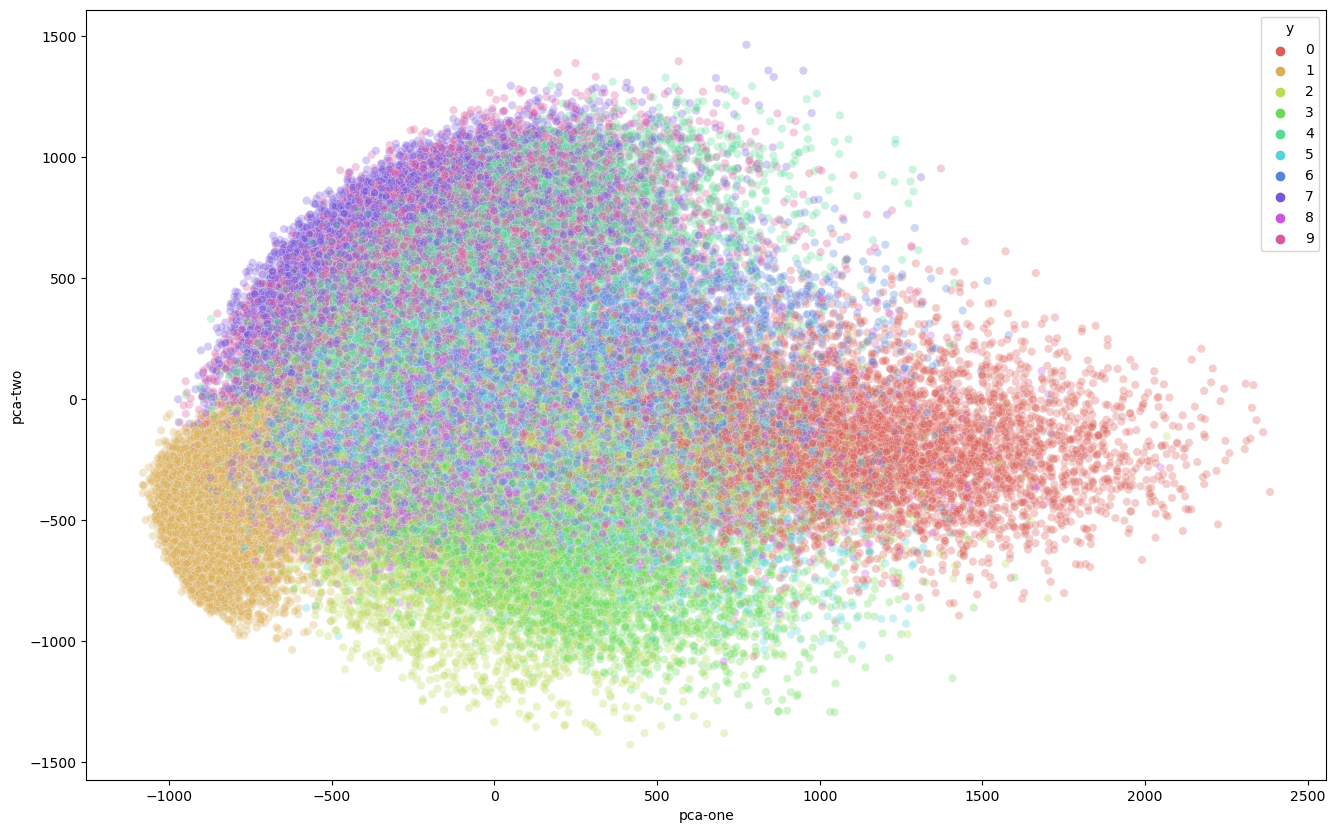

In [8]:
# Plot dataset with 2 PCA features, using same colour for data from each digit
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", 
    y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

We can see that even with 2 components, we can see a degree of separation between the data for each of the digits. However there is some overlap as well, so this is still not ideal for distinguishing the digits.

Lets see if we include all 3 PCA components if the separation is better, and we can plot this on a 3d scatterplot.

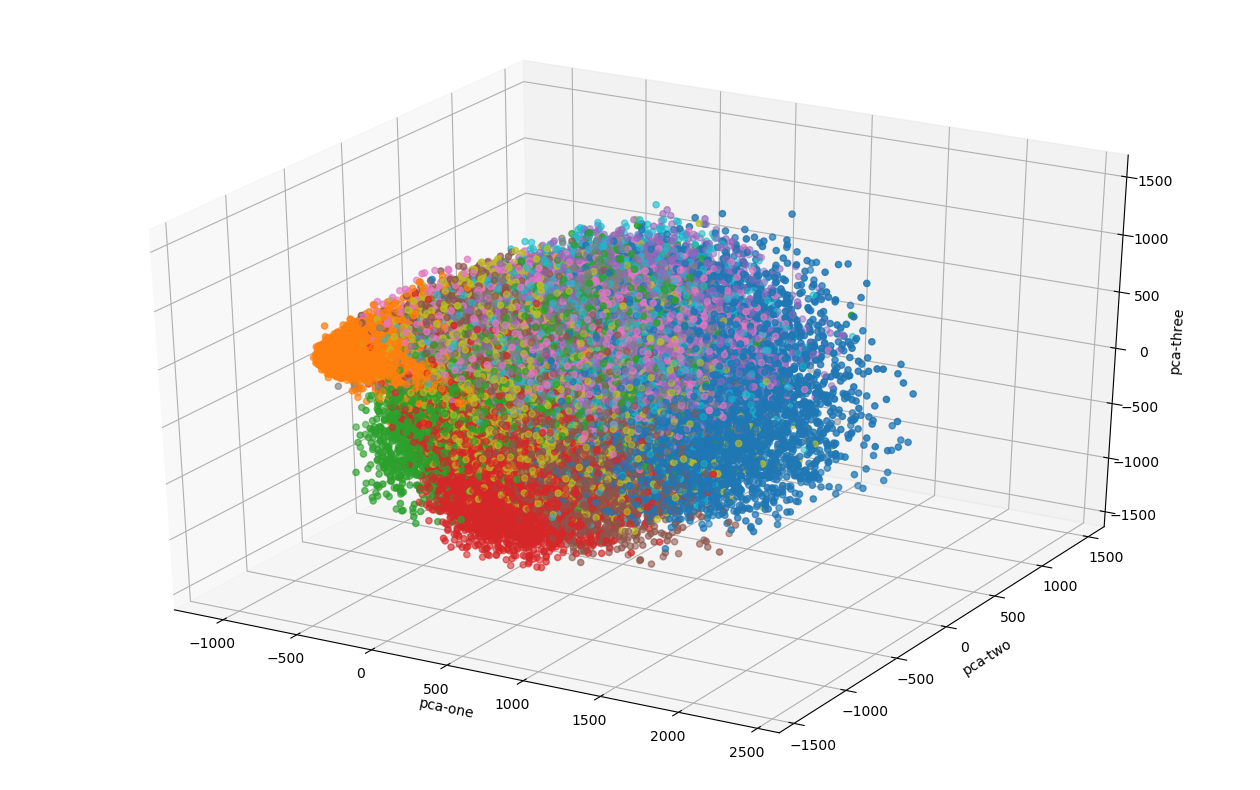

In [9]:
# Plot dataset with 3 PCA features, using same colour for data from each digit
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"].astype(int), 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

The separation between the digit data might be a little better, but there is still a high degree of overlap between the data for each of the digits. 

This might mean for example, if we were to feed this into an machine learning algorithm say to classify each of the digit images, that while it may have a degree of success - there could be several images it might have difficulty classifying.

## Reduce dimensionality using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space, and like PCA is a dimensionality reduction technique.

#### t-SNE vs PCA

What is the difference between t-SNE and PCA? PCA was developed much earlier (in 1933) whereas t-SNE was developed much more recently (in 2008) so much has changed in this time. t-SNE also differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance. This difference can potentially allow more of the varience to be preserved using t-SNE.

There are various pros and cons between using these 2 techniques which one should consider, which are nicely explained in [this](https://www.datacamp.com/community/tutorials/introduction-t-sne) article.

Let us first take a subset of the PCA transformed data which we will use later.

In [10]:
# Run PCA on subset
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09819946 0.07123677 0.06113222]


In [11]:
df_subset.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
46730     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
48393     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41416     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
34506     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
43725     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel9  ...  pixel779  pixel780  pixel781  pixel782  pixel783  y  \
46730     0.0  ...       0.0       0.0       0.0       0.0       0.0  8   
48393     0.0  ...       0.0       0.0       0.0       0.0       0.0  4   
41416     0.0  ...       0.0       0.0       0.0       0.0       0.0  8   
34506     0.0  ...       0.0       0.0       0.0       0.0       0.0  7   
43725     0.0  ...       0.0       0.0       0.0       0.0       0.0  7   

       label     pca-one     pca-two   pca-three  
46730      8  745.381841  430.145418 -339.427223  
48393      4 -220.059832 -635.210793 -366.888071  
41416      8  -81.382557  106.709057 -509.194536  
34506      7 -458.071481 -470.601067 -240.319225  
43725      7 -416.230281 -478.041459  394.779891  

[5 rows x 789 columns]

Now we will extract 2 t-SNE components from the dataset

In [12]:
# Create 2 components using t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.044s...
[t-SNE] Computed neighbors for 10000 samples in 6.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 540.083306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.837257
[t-SNE] KL divergence after 300 iterations: 2.786180
t-SNE done! Time elapse

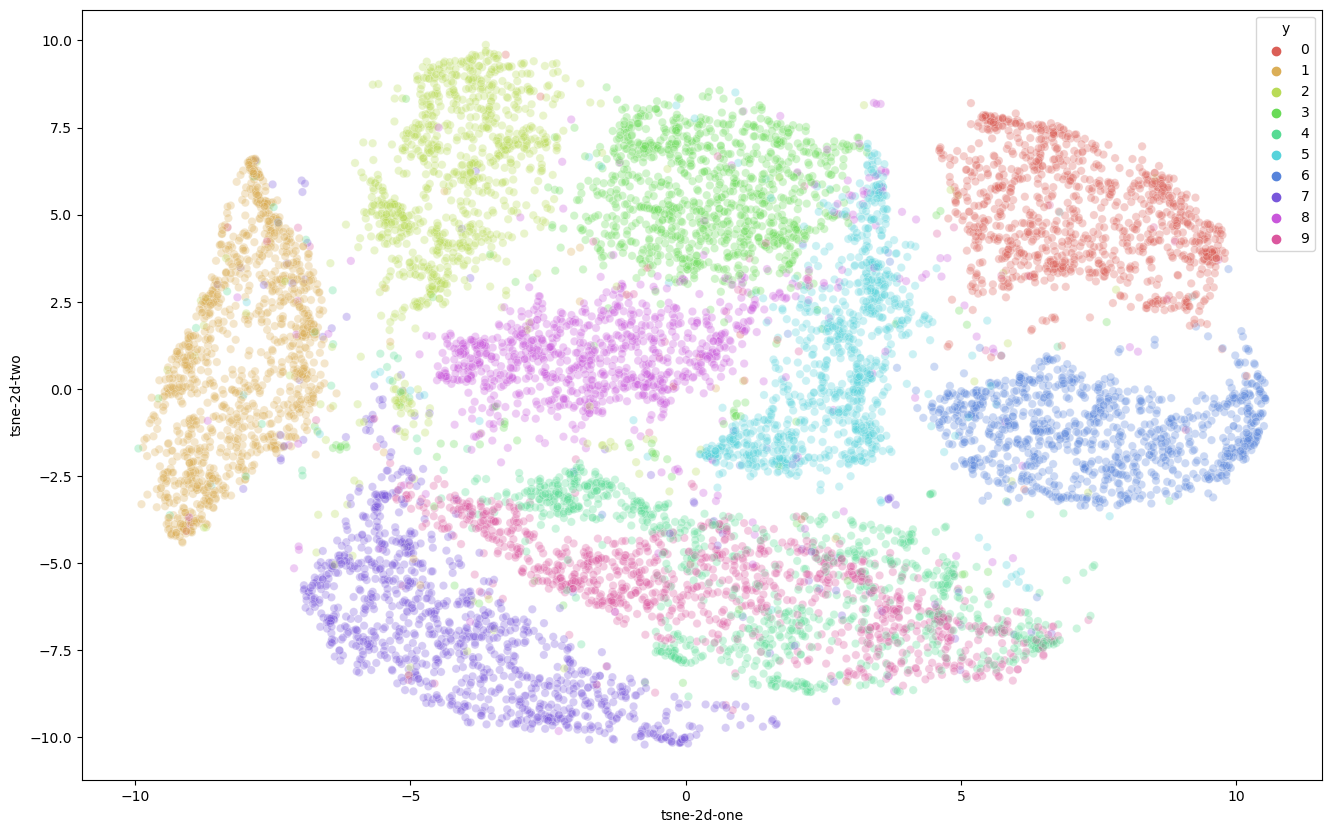

In [13]:
# Plot dataset with 2 t-SNE features, using same colour for data from each digit
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Here we can see a much nicer and clearer separation of the datapoints for each digit, clustered in their own sub-groups.

Also note the 'curvature' of each of the groups of points.

If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label. 

Let's just compare side by side the PCA and t-SNE plots.

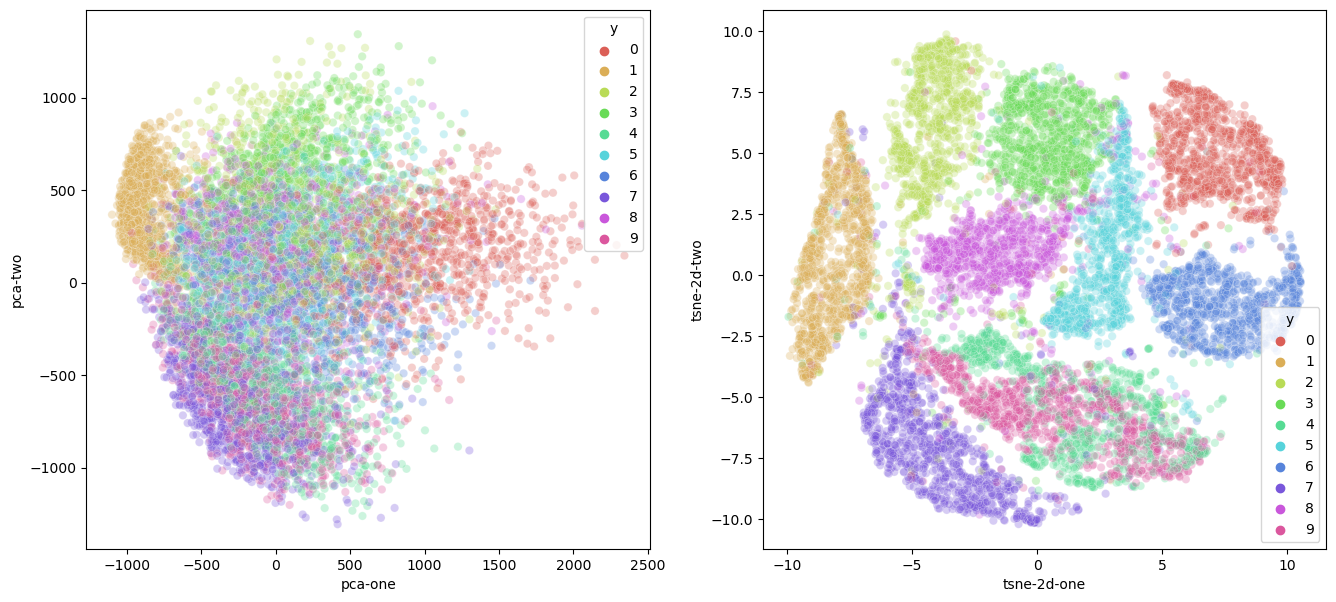

In [14]:
# Plot PCA and t-SNE datapoints side by side, coloured by digit
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

Lets try applying PCA first but with a higher number of components extracted, and then feed this into t-SNE

In [15]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8261659824816721


So it seems like the first 50 PCA components explain 82% of the varience.

Lets now take our reduced sample set to make sure its more easily computed to compare these different approaches so far.

In [16]:
# Apply t-SNE to enhanced PCA components
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 30.61000156402588 seconds


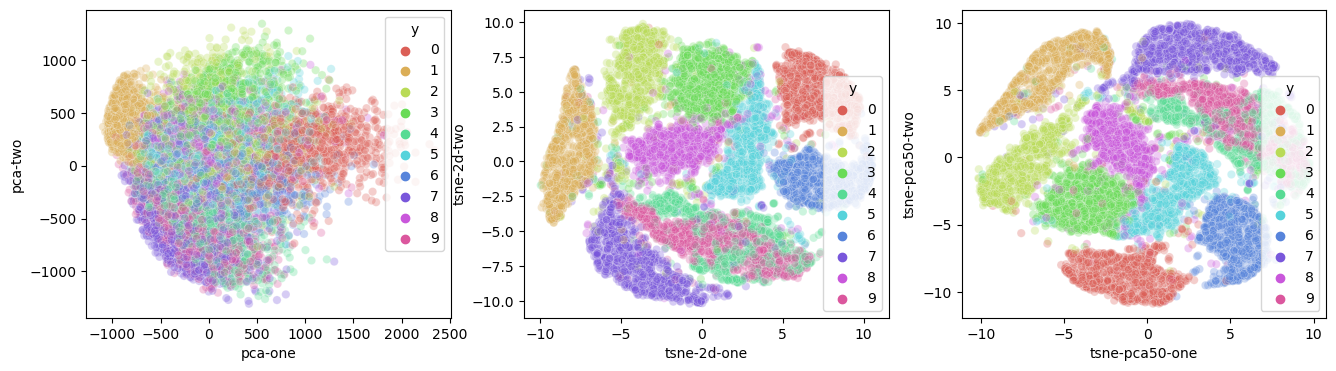

In [17]:
# Plot original PCA v original t-SNE v PCA+t-SNE
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

We can see how both the t-SNE and PCA enhanced t-SNE datasets have very nice groupings for the data for each digit, which could be very useful for example for any clustering or deep learning model.

It is also interesting to observe the results of applying PCA before t-SNE, as well as t-SNE alone.

## Discovering the 'shape' of data using TDA

PCA and t-SNE are both dimensionality reduction techniques i.e. every point in some high dimensional space gets assigned coordinates in some low dimensional space (typically two dimensions). Topological data analysis on the other hand, produces a more abstract representation of the data (a 'simplicial complex/ vietoris rips complex' summary of the original data - an amusing mathematical oxymoron!).  This complex could be said to represent the **shape** of the data, or a higher order representation of the data. The complex does not come with coordinates and should be considered a combinatorial representation of topological (and geometric) features of the original space.

A topological network (i.e. a graph) produced by TDA represents data by grouping similar data points into nodes, and connecting those nodes by an edge if the corresponding collections have a data point in common.  Because each node represents multiple data points, the network gives a compressed version of extremely high dimensional datasets.

TDA itself however can use dimensionality reduction schemes as part of the complex creation process - in fact - this is frequently very useful and many (including t-SNE) are used as "lenses".

But what is a 'lens'? to quote [Gurjeet Singh](https://www.quora.com/In-the-topological-data-analysis-approach-pioneered-by-Ayasdi-what-is-the-purpose-of-constructing-a-network-connecting-overlapping-clusters) (co-founder of Ayasdi - a pioneer in the field of TDA):

> "Imagine a circle in 3D space and imagine looking at it 'side-on' - you would see a line segment. This is a fine projection (lens), but loses the connectivity structure of the data - the fact that its connected up like a loop. Constructing edges allows us to see that. In other words, the edges reveal and allow us to interrogate the connectivity structure of the underlying data."

[TDA seeks to compare or understand global invariants of a dataset (persistent homology and its cousins)](https://www.quora.com/How-similar-is-Ayasdis-topological-data-analysis-to-t-Distributed-Stochastic-Neighbor-Embedding-tSNE) that characterise the **shape** of the data, or partition data for further applications of machine learning (Morse-Smale clustering, Mapper algorithm). TDA is a relatively recent technique, popularized in a [landmark paper by Gunnar Carlsson in 2009](http://www.ams.org/journals/bull/2009-46-02/S0273-0979-09-01249-X/S0273-0979-09-01249-X.pdf).

In this project we will make use of the mapper algorithm that uses TDA on our MNIST digits dataset, using the [Kepler Mapper library](https://kepler-mapper.scikit-tda.org).

In [18]:
# Load digits dat
data, labels = datasets.load_digits().data, datasets.load_digits().target

In [19]:
# Select similar subset of dataset as previous
N = 10000
df_subset2 = df.loc[rndperm[:N],:].copy()
df_subset2 = df_subset2.reset_index()
data_subset2 = df_subset2[feat_cols].values

In [42]:
# Initialize to use t-SNE with 2 components (reduces data to 2 dimensions). Also note high overlap_percentage.
# mapper = km.KeplerMapper(verbose=2)

# # Fit and transform data
# projected_data = mapper.fit_transform(data_subset2,
#                                       projection=sklearn.manifold.TSNE())

# # Create the graph (we cluster on the projected data and suffer projection loss)
# graph = mapper.map(projected_data,
#                    clusterer=sklearn.cluster.DBSCAN(eps=0.3, min_samples=15),
#                    cover=km.Cover(35, 0.2))

# Create the visualizations (increased the graph_gravity for a tighter graph-look.)
print("Output graph examples to html" )
# Tooltips with the target y-labels for every cluster member
def square(number):
  return [number, 'green']

lens_iter = map(square, df_subset2['y'].values)

print('color-function', lens_iter)
print(type(df_subset2['y'].values))
# print('color-function', lens_iter)   
# df_subset2.head()
# mapper.visualize(graph,
#                  title="Handwritten digits Mapper",
#                  path_html="tda_mnist_digits.html",
#                  color_function_name=df_subset2['y'].values,
#                  custom_tooltips=df_subset2['y'].values,
#                  color_values=lens
#                  )
                 

Output graph examples to html
color-function <map object at 0x7f0dc0bede20>
<class 'pandas.core.arrays.categorical.Categorical'>


![title](img/tda1.png)

In the network diagram above we can see distinct cluster's of 'nodes' (each of which relates to multiple data points) as well as clusters that appear to have clear 'connecting points' to other clusters.

It's also interesting to observe the 'curvature' in these clusters similar to the clusters observed in PCA and t-SNE, but with a more sparse network (than the more dense plots of the formentioned dimensionality reduction techniques).

Each node is coloured in relation to a particular digit. Given there are far less points on this visualisation, it is easier to see not only the distinct groupings but the specific points at which some of these groupings connect with each other (as compared to say the plots of both PCA and t-SNE on the same data).

In fact the network is rendered as a fully interactive & animated web page where one can move around nodes and structures, and click on individual nodes to discover what data points (and digits) each node is made up of. You can see an interactive version of this topological network [here](https://pranath.github.io/high_dim_data_vis/tda_mnist_digits.html) just zoom out (using say a mouse) on the page to see the overall network structure.

Below is an annotated version of the network diagram with clusters that relate to each digit (and the digit they relate to) highlighted in red.

![title](img/tda2.png)

We can see many interesting aspects here already that would be very difficult if not impossible to observe from the plots from PCA or T-SNE. We can see for example that the groups for digits: 0, 1, 2 & 6 are completely distinct groups. This suggets that most images for these digits have a fundamentally distinguished morphology.

We can also see for example that the groups for digits 5,3,8 seem to have particular connecting nodes i.e. relationships - commonality between their inherrent structure is suggested in various places.

Similarly for digit groups 7, 9 & 4 there are connecting nodes, suggesting commonality and relationships between these groups/digits.

Let us explore the relationships between these groups, by looking at node 'A' and node 'B' (annotated in green in the network diagram) which are connecting nodes between these groups respectively.

We can explore these relationships by looking at the images that comprise of these particular nodes.

Let us first look at node A, which is a connecting point between digits 5, 3 & 8.

<Figure size 432x288 with 0 Axes>

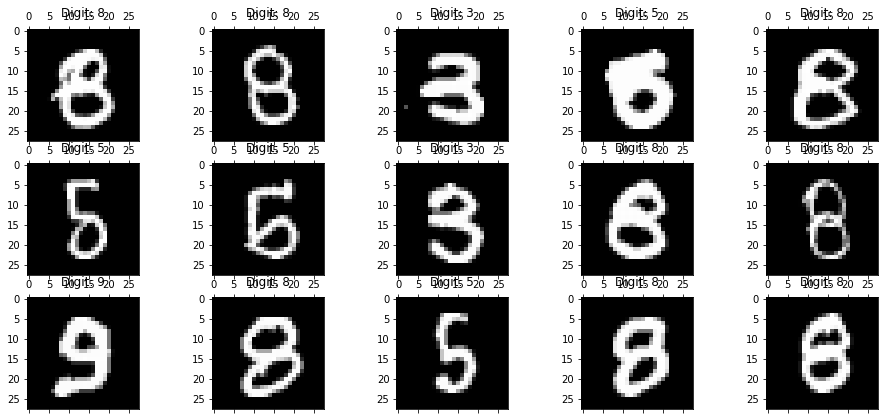

In [ ]:
# Node A (Digits: 5/3/8)
# cube264_cluster0
# Print examples
clusterA = graph.get("nodes").get("cube264_cluster0")

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df_subset2.loc[clusterA[i],'label'])) )
    ax.matshow(df_subset2.loc[clusterA[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

We can see from the above digit examples from Node A the similarity that the topological network was suggesting between these 3 digits, in these particular examples of the digits the stucture of the digits are very similar to each other, despite being different digits!

Let us now look at node B, which is a connecting point between digits 7 & 9.

<Figure size 432x288 with 0 Axes>

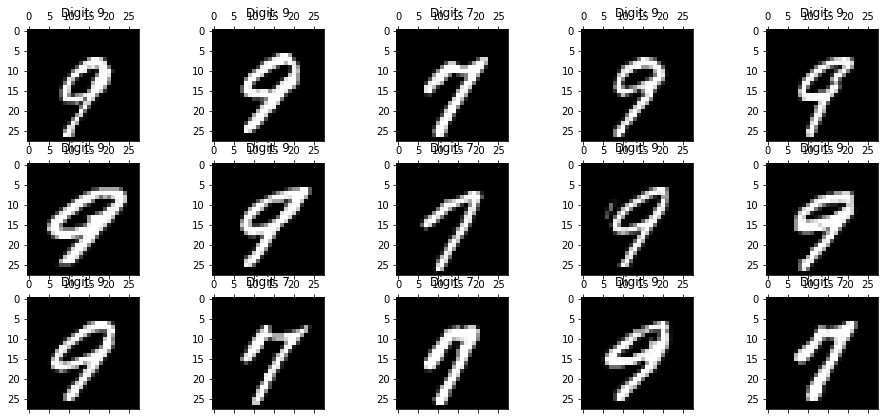

In [ ]:
# Node B (Digits: 7/9)
# cube264_cluster0
# Print examples
clusterB = graph.get("nodes").get("cube639_cluster0")

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df_subset2.loc[clusterB[i],'label'])) )
    ax.matshow(df_subset2.loc[clusterB[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

Similarly, we can see how these digit examples are very similar in structure, despite representing the different digits of 7 & 9.

In these two examples, we have seen how TDA can make it much easier to understand the fundamental structure of the data and its key underlying relationships. 

We could use this topological network in several different ways. For example, we could use it as a tool to further understand more about the nature, fundamental structure and underlying relationships of the data as we have above. We could also use it and the clusters it has produced as input to a machine learning algorithm i.e. to classify help images.

One of the main ideas coming from topological data analysis is that ['data has shape, and shape matters'](https://www.ayasdi.com/blog/bigdata/why-topological-data-analysis-works/). In these examples, we have seen a glimpse of what this actually means in practice on a dataset.

## Discussion

It's been facinating in this project to observe the differences and similarities between these 3 methods of visulising and understanding higher dimensional data on the MNIST digit dataset, while also considering the historical aspects of these techniques (i.e. older v newer). Some of these techniques are very well known and have been around for quite a while (i.e. PCA) much like a familiar pair of old slippers! while t-SNE & TDA are the relatively shiney new shoes in town, and especially in the case of TDA - hardly even worn and barely explored for its full potential.

In terms of similarities, all 3 techniques could be used to assist with classification tasks, helping to structure the data in such a way as to make that task easier for ML algorithms. All 3 techniques can also be used to visulise the data in order to help further understanding of the dataset (note also the 'curvature' aspect of the clusters shared by t-SNE and TDA).

In terms of differences, it be argued that the more recent techniques (t-SNE & TDA) in many cases might help do a better job on clustering the data for classification, due to the way they seem to better distinguish and cluster the data more clearly. Furthermore, with regards to helping understand the fundamental structure and relationships in the dataset, we have seen how TDA due to its higher level of abstraction and simplification of the datset can make it much easier to gain greater insights into this - far more than the more granular and 'noisey' visualisations of the dimensionality reduction techniques (PCA & t-SNE). 

Some recent applications of TDA include for example include [very complex genetic datasets](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3084136/) of many thousands of features, [which have enabled data scientists to discover specific genetic markers that might help better predict various forms of cancer](https://towardsdatascience.com/the-shape-of-the-genome-going-beyond-the-double-helix-with-topological-data-analysis-29021b860ebc) and hint at the huge potential of this technique to help derive useful insights from ever more complex datasets.

Ultimately of course these are all just tools, rather than any one of these being a magic bullet to solve all problems! And for a particular use case scenario, any one of these could be sufficient or helpful for the task at hand and the dataset in question.

As a final thought, we might also consider what it mean's to be 'data driven' and how it might relate to these different techniques. In a recent article chief data scientist at google Cassie Kozyrkov asks ['Data-Driven? Think again'](https://hackernoon.com/data-inspired-5c78db3999b2). Her main point is that many data scientists can fall into the trap of being less objective and not really being data-driven in their methodology i.e. allowing their own assumptions and biases to cloud their interpretations or ways of looking at the data. In other words, that data scientists while often claiming to be more objective and evidence based can easily fall victim to the [Confirmation bias](https://www.verywellmind.com/what-is-a-confirmation-bias-2795024) as much as anyone else! That is, interpreting evidence to fit our pre-exisiting beliefs.

![title](img/confbias.png)

But how does this relate to the 3 different techniques of visualisation we have explored? It could be argued that the dimensionality reduction techniques have more pre-exisiting assumptions both in terms of how the data is reduced and also in terms of the very question we consider is worthy to pose and answer e.g. 'this data represents digits, we should focus on trying to classify them better'. So in some ways, these approaches seems less data driven. 

On the other hand, while TDA also has various assumptions including in how the data is simplified, there is less intent to 'force' the data into a particular format that lends itself to an intent i.e. 'I want clearer groups to classify the images by their digits' and more intent to reveal the nature of the dataset itself, its structure and underlying relationships. As we saw, this approach lends itself more not only to seeing the data quite differently, but also to realising other questions may also be interesting to ask e.g. why are digits 5, 3 and 8 so similar in some cases? It would seem to me that TDA lends itself to being naturally a more data-driven approach than either PCA or t-SNE.

## Conclusion

In this project we have explored 3 different techniques for visualising and understanding higher dimensional datasets:

- PCA
- t-SNE
- TDA

We have seen how each of these has various strengths and weaknesses depending on the purpose and dataset you might have in question. None of these is a silver bullet that will solve all your problems on a particular project! However familarity with all 3 of these techniques could be extremely useful to have in a data scientists toolbox.

## References & further reading

#### PCA and t-SNE

https://www.datacamp.com/community/tutorials/introduction-t-sne

#### Topological data analysis

https://www.ayasdi.com/resources/videos/introduction-to-topological-data-analysis/

https://www.ayasdi.com/blog/topology/topological-data-analysis-a-framework-for-machine-learning/

https://www.ayasdi.com/blog/bigdata/why-topological-data-analysis-works/

https://www.youtube.com/watch?v=FmfIJ3-UuaI

https://towardsdatascience.com/tda-to-rule-them-all-tomato-clustering-878e03394a1

https://towardsdatascience.com/from-tda-to-dl-d06f234f51d

https://towardsdatascience.com/a-concrete-application-of-topological-data-analysis-86b89aa27586

https://www.kdnuggets.com/2018/01/topological-data-analysis.html

https://www.thekerneltrip.com/statistics/topological-data-analysis-tutorial/